In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('indices_df_cbrt.xlsx')

training_df.head()

,DWSI,MSI,LWVI1,LWVI2,NDII,NDWI,WBI,NMDI,SD,SR,ND,MDATT,Water Potential (Mpa)_cbrt
0,0.638643,0.619809,0.012191,0.036253,0.207077,0.045833,0.966546,0.470443,0.0019,1.008585,0.004274,-4.653659,-0.447529
1,0.834900,0.621971,0.007679,0.034491,0.205956,0.045102,0.971001,0.491520,-0.0005,1.007701,0.003836,-4.671958,-0.529240
2,0.880338,0.619670,0.010875,0.034380,0.208122,0.043521,0.969639,0.464310,0.0015,1.007349,0.003661,-5.006944,-0.504287
3,0.877961,0.599918,0.013940,0.040439,0.218082,0.042208,0.971235,0.462263,0.0008,1.008466,0.004215,-5.270142,-0.548242
4,1.190506,0.566488,0.012489,0.043199,0.246819,0.051212,0.964867,0.476835,0.0003,1.007552,0.003762,-4.881773,-0.688325


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)_cbrt'])
y = training_df['Water Potential (Mpa)_cbrt']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 01:01:00,753] A new study created in memory with name: no-name-4c418bd9-c7b6-464f-8c41-1acd74cdbe84
[I 2024-02-26 01:01:00,778] Trial 0 finished with value: 0.1229283468213501 and parameters: {'n_components': 12, 'max_iter': 518}. Best is trial 0 with value: 0.1229283468213501.
[I 2024-02-26 01:01:00,784] Trial 1 finished with value: 0.07648305574442754 and parameters: {'n_components': 3, 'max_iter': 624}. Best is trial 1 with value: 0.07648305574442754.
[I 2024-02-26 01:01:00,797] Trial 2 finished with value: 0.10223926011086362 and parameters: {'n_components': 8, 'max_iter': 716}. Best is trial 1 with value: 0.07648305574442754.
[I 2024-02-26 01:01:00,802] Trial 3 finished with value: 0.0740967236620623 and parameters: {'n_components': 2, 'max_iter': 771}. Best is trial 3 with value: 0.0740967236620623.
[I 2024-02-26 01:01:00,815] Trial 4 finished with value: 0.07214962148862374 and parameters: {'n_components': 4, 'max_iter': 778}. Best is trial 4 with value: 0.07214962

[I 2024-02-26 01:01:02,105] Trial 45 finished with value: 0.07709207411896725 and parameters: {'n_components': 1, 'max_iter': 517}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:02,170] Trial 46 finished with value: 0.07648305574442754 and parameters: {'n_components': 3, 'max_iter': 244}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:02,230] Trial 47 finished with value: 0.10181279976067704 and parameters: {'n_components': 9, 'max_iter': 380}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:02,278] Trial 48 finished with value: 0.08377295689417552 and parameters: {'n_components': 6, 'max_iter': 432}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:02,316] Trial 49 finished with value: 0.07595794174360603 and parameters: {'n_components': 5, 'max_iter': 758}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:02,417] Trial 50 finished with value: 0.0740967236620623 and parameters: {'

[I 2024-02-26 01:01:03,699] Trial 91 finished with value: 0.07214962148862374 and parameters: {'n_components': 4, 'max_iter': 656}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:03,732] Trial 92 finished with value: 0.07214962148862374 and parameters: {'n_components': 4, 'max_iter': 667}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:03,770] Trial 93 finished with value: 0.07214962148862374 and parameters: {'n_components': 4, 'max_iter': 506}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:03,809] Trial 94 finished with value: 0.07595794174360603 and parameters: {'n_components': 5, 'max_iter': 752}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:03,856] Trial 95 finished with value: 0.07648305574442754 and parameters: {'n_components': 3, 'max_iter': 553}. Best is trial 4 with value: 0.07214962148862374.
[I 2024-02-26 01:01:03,911] Trial 96 finished with value: 0.07214962148862374 and parameters: {

Number of finished trials:  100
Best trial:
  Value: 0.07214962148862374
  Params: 
    n_components: 4
    max_iter: 778
Mean Squared Error: 0.07214962148862374
Root Mean Squared Error: 0.26860681578959184
R-Squared value: 0.4865072790319511


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
SR: 0.1021189205276715
ND: 0.10168929352061828
SD: 0.07803670656417855


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 01:01:04,135] A new study created in memory with name: no-name-9d35a673-2c2d-4bc2-b020-6417604c41a8
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:04,142] Trial 0 finished with value: 0.17199074459158273 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 0.17199074459158273.
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:04,238] Trial 10 finished with value: 0.07663214019036184 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 7 with value: 0.0741133092082338.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecat

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:04,489] Trial 20 finished with value: 0.15149446663117871 and parameters: {'alpha': 0.643910652660838, 'l1_ratio': 0.26657424370799765, 'max_iter': 430}. Best is trial 7 with value: 0.0741133092082338.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:04,725] Trial 30 finished with value: 0.11180656896662146 and parameters: {'alpha': 0.20013122393698424, 'l1_ratio': 0.5522946268924429, 'max_iter': 100}. Best is trial 27 with value: 0.07213046241167856.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been depreca

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:04,972] Trial 39 finished with value: 0.07728065758300068 and parameters: {'alpha': 0.04564610235619748, 'l1_ratio': 0.7043594308972366, 'max_iter': 316}. Best is trial 27 with value: 0.07213046241167856.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been depreca

[I 2024-02-26 01:01:05,204] Trial 48 finished with value: 0.10788859338824519 and parameters: {'alpha': 0.17458551245150522, 'l1_ratio': 0.5936564008686747, 'max_iter': 178}. Best is trial 27 with value: 0.07213046241167856.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:05,231] Trial 49 finished with value: 0.0724279971147752 and parameters: {'alpha': 0.029419769577097212, 'l1_

[I 2024-02-26 01:01:05,443] Trial 57 finished with value: 0.09967373115459775 and parameters: {'alpha': 0.17506422165292282, 'l1_ratio': 0.4988783507778525, 'max_iter': 439}. Best is trial 53 with value: 0.07200467583209628.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:05,470] Trial 58 finished with value: 0.07604704101458212 and parameters: {'alpha': 0.15249508106392695, 'l1_

[I 2024-02-26 01:01:05,687] Trial 66 finished with value: 0.17199074459158273 and parameters: {'alpha': 0.6577513470431062, 'l1_ratio': 0.3679383047437573, 'max_iter': 162}. Best is trial 64 with value: 0.07187484629187921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:05,714] Trial 67 finished with value: 0.07335147943727406 and parameters: {'alpha': 0.043376160463234927, 'l1_

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.524e-01, tolerance: 4.049e-04
  model = cd_fast.enet_coordinate_descent(
[I 2024-02-26 01:01:05,967] Trial 76 finished with value: 0.08890642512000291 and parameters: {'alpha': 0.00011799058429408371, 'l1_ratio': 0.3272211269312293, 'max_iter': 131}. Best is trial 64 with value: 0.07187484629187921.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: Futur

[I 2024-02-26 01:01:06,252] Trial 85 finished with value: 0.15978099005044985 and parameters: {'alpha': 0.5678751469222749, 'l1_ratio': 0.33638468563501883, 'max_iter': 284}. Best is trial 84 with value: 0.07187468760834397.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:06,280] Trial 86 finished with value: 0.08642051053315923 and parameters: {'alpha': 0.14172444184664942, 'l1_

[I 2024-02-26 01:01:06,542] Trial 95 finished with value: 0.08082121569996266 and parameters: {'alpha': 0.16397597765144317, 'l1_ratio': 0.23849976006105647, 'max_iter': 442}. Best is trial 84 with value: 0.07187468760834397.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 01:01:06,573] Trial 96 finished with value: 0.07356457601294207 and parameters: {'alpha': 0.0844056596832459, 'l1_

Number of finished trials:  100
Best trial:
  Value: 0.07187468760834397
  Params: 
    alpha: 0.0337340880464839
    l1_ratio: 0.39864258295027427
    max_iter: 289
Mean Squared Error: 0.07187468760834397
Root Mean Squared Error: 0.2680945497550145
R-Squared value: 0.4884639981852653


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
SD: 0.07432083357940533
SR: 0.06514986854053864
MDATT: 0.06241963273999775


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 01:01:06,703] A new study created in memory with name: no-name-c1ff5d41-7b83-4b41-bf52-ad5fc437bab1
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:06,726] Trial 0 finished with value: 0.727702221383224 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 0.727702221383224.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:06,798] Trial 10 finished with value: 0.11245602288440075 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 0.11245602288440075.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform ha

[I 2024-02-26 01:01:06,960] Trial 19 finished with value: 0.8216402357319528 and parameters: {'alpha': 0.4951432982760322, 'gamma': 0.552640602589324, 'kernel': 'rbf'}. Best is trial 13 with value: 0.07258235083830146.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:06,978] Trial 20 finished with value: 0.06856522099955174 and parameters: {'alpha': 0.122496971066771

[I 2024-02-26 01:01:07,139] Trial 29 finished with value: 1.1498802008723046 and parameters: {'alpha': 0.9668894200089733, 'gamma': 1.3021642335667183, 'kernel': 'rbf'}. Best is trial 21 with value: 0.06809799875723274.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:07,160] Trial 30 finished with value: 1.3324893712054275 and parameters: {'alpha': 0.771628816117933

[I 2024-02-26 01:01:07,326] Trial 39 finished with value: 1.3324893707347698 and parameters: {'alpha': 0.5060830663107351, 'gamma': 53.59087521215299, 'kernel': 'rbf'}. Best is trial 21 with value: 0.06809799875723274.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:07,343] Trial 40 finished with value: 0.08219668698205428 and parameters: {'alpha': 0.052919807279376

[I 2024-02-26 01:01:07,507] Trial 49 finished with value: 0.06768668825202863 and parameters: {'alpha': 0.1265667118642026, 'gamma': 0.011210247132386147, 'kernel': 'rbf'}. Best is trial 49 with value: 0.06768668825202863.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:07,525] Trial 50 finished with value: 1.3324893712054278 and parameters: {'alpha': 0.060785875452

[I 2024-02-26 01:01:07,681] Trial 59 finished with value: 0.06971975329357893 and parameters: {'alpha': 0.08776124124755895, 'gamma': 0.00462066924989467, 'kernel': 'rbf'}. Best is trial 54 with value: 0.0669382676469871.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:07,699] Trial 60 finished with value: 1.2092901023865208 and parameters: {'alpha': 0.0090091075200

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:07,862] Trial 69 finished with value: 0.09603571206672722 and parameters: {'alpha': 0.2382299275137536, 'gamma': 0.0012715009137896117, 'kernel': 'rbf'}. Best is trial 54 with value: 0.0669382676469871.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform ha

[I 2024-02-26 01:01:08,070] Trial 78 finished with value: 0.06846267530394747 and parameters: {'alpha': 0.15144157185157425, 'gamma': 0.013790231286031565, 'kernel': 'rbf'}. Best is trial 54 with value: 0.0669382676469871.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:08,091] Trial 79 finished with value: 0.124162392220848 and parameters: {'alpha': 0.5123190222453

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:08,297] Trial 89 finished with value: 1.3324893712054278 and parameters: {'alpha': 0.03102539096362479, 'gamma': 822070.350964676, 'kernel': 'rbf'}. Best is trial 84 with value: 0.06635109102578989.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been 

[I 2024-02-26 01:01:08,485] Trial 98 finished with value: 0.08448289286233425 and parameters: {'alpha': 0.000950639756829269, 'gamma': 0.002613086719100038, 'kernel': 'rbf'}. Best is trial 94 with value: 0.06630718510535451.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 01:01:08,503] Trial 99 finished with value: 0.17880938366675994 and parameters: {'alpha': 0.562365270

Number of finished trials:  100
Best trial:
  Value: 0.06630718510535451
  Params: 
    alpha: 0.07259422468421528
    gamma: 0.017034777388719148
    kernel: rbf
Mean Squared Error: 0.06630718510535451
Root Mean Squared Error: 0.25750181573215075
R-Squared value: 0.5280882117330419


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
SD: 25.916844766303786
NDWI: 11.177496906268443
NMDI: 9.529485016778612


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 2


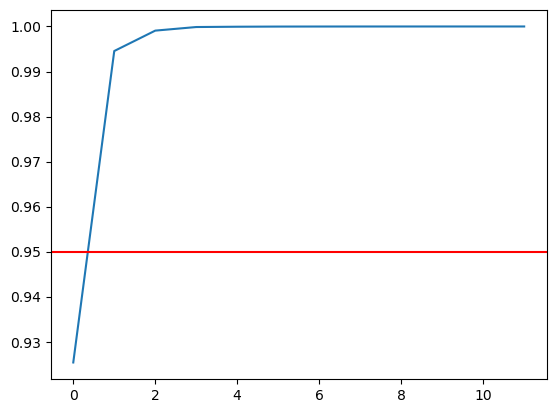

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 0.07683299029737309
Root Mean Squared Error: 0.27718764456117645
R-Squared value: 0.4531754923464064


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
SD: 0.2387408105787521
NDII: 0.20119807288077493
DWSI: 0.19727027835934238


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 01:01:08,798] A new study created in memory with name: no-name-5194d56a-bb74-4577-a083-bdb1e8d7ec35
[I 2024-02-26 01:01:08,999] Trial 0 finished with value: 0.105321085874317 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.105321085874317.
[I 2024-02-26 01:01:09,144] Trial 1 finished with value: 0.12606082313263364 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.105321085874317.
[I 2024-02-26 01:01:09,245] Trial 2 finished with value: 0.11737233864145051 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.105321085874317.
[I 2024-02-26 01:01:09,367] Trial 3 finished with value: 0.09319945476484383 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value:

[I 2024-02-26 01:01:15,790] Trial 36 finished with value: 0.08575729815172327 and parameters: {'n_estimators': 116, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.08010290854552377.
[I 2024-02-26 01:01:16,006] Trial 37 finished with value: 0.08089018036277061 and parameters: {'n_estimators': 126, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.08010290854552377.
[I 2024-02-26 01:01:16,230] Trial 38 finished with value: 0.0840613227464002 and parameters: {'n_estimators': 137, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.08010290854552377.
[I 2024-02-26 01:01:16,425] Trial 39 finished with value: 0.08969550125022185 and parameters: {'n_estimators': 125, 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 16 with value: 0.08010290854552377.
[I 2024-02-26 01:01:16,612] Trial 40 finished with value: 0.1229799728444096

[I 2024-02-26 01:01:22,021] Trial 72 finished with value: 0.08612553676395142 and parameters: {'n_estimators': 71, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.07960398914126293.
[I 2024-02-26 01:01:22,202] Trial 73 finished with value: 0.08806027131332105 and parameters: {'n_estimators': 99, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.07960398914126293.
[I 2024-02-26 01:01:22,435] Trial 74 finished with value: 0.09137617420447502 and parameters: {'n_estimators': 117, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 64 with value: 0.07960398914126293.
[I 2024-02-26 01:01:22,558] Trial 75 finished with value: 0.08604986641735218 and parameters: {'n_estimators': 61, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 64 with value: 0.07960398914126293.
[I 2024-02-26 01:01:22,708] Trial 76 finished with value: 0.08951433696918501 an

Best trial:
  Value: 0.07720601279146043
  Params: 
    n_estimators: 94
    max_depth: 7
    min_samples_split: 2
    min_samples_leaf: 3
Mean Squared Error: 0.08393358034821599
Root Mean Squared Error: 0.2897129274785921
R-Squared value: 0.40264021259776794


## <font color = darkblue> Variable Importance Information of RF

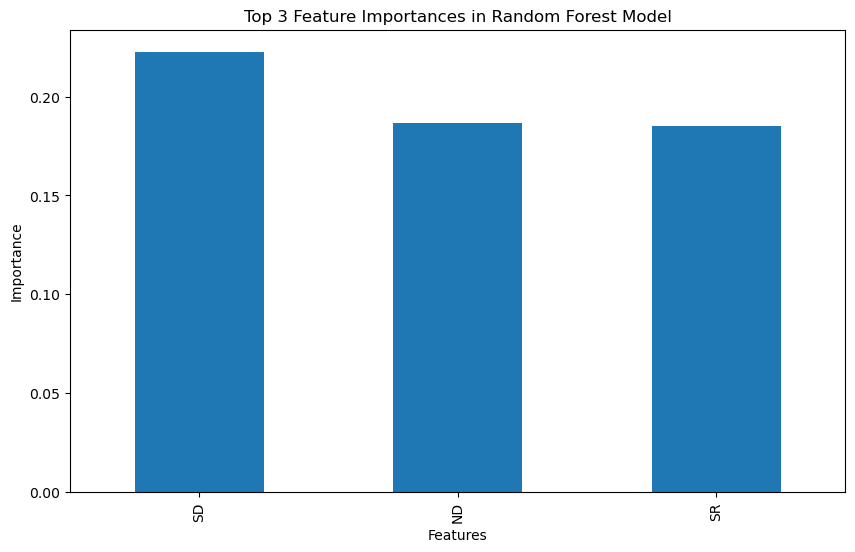

In [15]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a series with feature names and their importance
features = pd.Series(feature_importances, index = X.columns)

# Sort the features by importance
features = features.sort_values(ascending=False)

# Select the top 3 features
top_3_features = features[:3]

# Plot the top 3 feature importances
plt.figure(figsize=(10, 6))
top_3_features.plot(kind='bar')
plt.title('Top 3 Feature Importances in Random Forest Model')
plt.ylabel('Importance')
plt.xlabel('Features')

plt.show()

## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-02-26 01:01:27,112] A new study created in memory with name: no-name-457767a0-da13-44d7-8b03-4d47e0d9e34d
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:27,355] Trial 0 finished with value: 0.12567354596344915 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 0.12567354596344915.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.su

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:29,142] Trial 14 finished with value: 0.11984047222201345 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.012326639396245958}. Best is trial 10 with value: 0.09685349127087113.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:29,226] Trial 1

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:30,506] Trial 28 finished with value: 0.12239308735398959 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.010965414779760926}. Best is trial 10 with value: 0.09685349127087113.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:30,655] Trial 2

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:31,747] Trial 42 finished with value: 0.10040283960369578 and parameters: {'n_estimators': 87, 'max_depth': 3, 'learning_rate': 0.024175753222273447}. Best is trial 10 with value: 0.09685349127087113.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:31,832] Trial 4

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:32,987] Trial 56 finished with value: 0.12384680402866378 and parameters: {'n_estimators': 75, 'max_depth': 4, 'learning_rate': 0.03797417094523738}. Best is trial 10 with value: 0.09685349127087113.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:33,092] Trial 57

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:34,001] Trial 70 finished with value: 0.10045920195279572 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.060443807347394116}. Best is trial 10 with value: 0.09685349127087113.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:34,065] Trial 7

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:35,034] Trial 84 finished with value: 0.09943274164746609 and parameters: {'n_estimators': 57, 'max_depth': 3, 'learning_rate': 0.059120752037688025}. Best is trial 83 with value: 0.09219172629143454.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:35,104] Trial 8

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:36,121] Trial 98 finished with value: 0.11022540418994999 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.06273860690216981}. Best is trial 83 with value: 0.09219172629143454.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 01:01:36,203] Trial 9

Best trial:
  Value: 0.09219172629143454
  Params: 
    n_estimators: 57
    max_depth: 3
    learning_rate: 0.04542263721581115
Mean Squared Error: 0.10130256449275507
Root Mean Squared Error: 0.31828063794826583
R-Squared value: 0.27902422203797606


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
SR: 0.2429581732060739
MDATT: 0.20735395275099705
ND: 0.17581085067689986


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 01:01:36,284] A new study created in memory with name: no-name-9409596c-0cea-42eb-8ba6-82899cf9f487
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-02-26 01:01:36,580] Trial 6 finished with value: 0.09762115295851173 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 3 with value: 0.07740634038074033.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 01:01:37,634] Trial 19 finished with value: 0.07047964861013217 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.04577903889854292, 'min_child_weight': 2, 'subsample': 0.6182963931772821, 'colsample_bytree': 0.6852303352298368}. Best is trial 19 with value: 0.07047964861013217.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 01:01:38,863] Trial 32 finished with value: 0.07557922693914122 and parameters: {'n_estimators': 129, 'max_depth': 5, 'learning_rate': 0.02837253451862542, 'min_child_weight': 2, 'subsample': 0.5755025053330421, 'colsample_bytree': 0.8383409056051941}. Best is trial 19 with value: 0.07047964861013217.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 01:01:40,270] Trial 45 finished with value: 0.08070323207922704 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.04754858800371444, 'min_child_weight': 2, 'subsample': 0.5716632175920532, 'colsample_bytree': 0.5672085587593187}. Best is trial 19 with value: 0.07047964861013217.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-26 01:01:41,332] Trial 58 finished with value: 0.08317686912276917 and parameters: {'n_estimators': 79, 'max_depth': 3, 'learning_rate': 0.02490951670409193, 'min_child_weight': 4, 'subsample': 0.6901869453893035, 'colsample_bytree': 0.6422498266024343}. Best is trial 53 with value: 0.06975513006978142.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/

[I 2024-02-26 01:01:42,010] Trial 64 finished with value: 0.07810471250391703 and parameters: {'n_estimators': 80, 'max_depth': 8, 'learning_rate': 0.04577408273748426, 'min_child_weight': 3, 'subsample': 0.7714712097720436, 'colsample_bytree': 0.5446497471506501}. Best is trial 53 with value: 0.06975513006978142.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-26 01:01:43,391] Trial 77 finished with value: 0.090131631901011 and parameters: {'n_estimators': 98, 'max_depth': 9, 'learning_rate': 0.04330572956472097, 'min_child_weight': 6, 'subsample': 0.6183647647787915, 'colsample_bytree': 0.5547182181605457}. Best is trial 53 with value: 0.06975513006978142.
/var/folders/3h/

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-02-26 01:01:44,852] Trial 90 finished with value: 0.08806564296273854 and parameters: {'n_estimators': 112, 'max_depth': 10, 'learning_rate': 0.013722149194379241, 'min_child_weight': 1, 'subsample': 0.5170234159050854, 'colsample_bytree': 0.5943264485327916}. Best is trial 82 with value: 0.06769404179100078.
/var/folder

[I 2024-02-26 01:01:45,414] Trial 96 finished with value: 0.06987169479653105 and parameters: {'n_estimators': 104, 'max_depth': 7, 'learning_rate': 0.04150434143066581, 'min_child_weight': 2, 'subsample': 0.5959960560990224, 'colsample_bytree': 0.6257102837049755}. Best is trial 82 with value: 0.06769404179100078.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_48044/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

Best trial:
  Value: 0.06769404179100078
  Params: 
    n_estimators: 104
    max_depth: 8
    learning_rate: 0.027453643611133127
    min_child_weight: 3
    subsample: 0.5983067869524757
    colsample_bytree: 0.5903156374565479
Mean Squared Error: 0.06769404179100078
Root Mean Squared Error: 0.2601807867445265
R-Squared value: 0.5182178784116465


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
SD: 0.16954925656318665
MDATT: 0.1583801656961441
SR: 0.1551007479429245
